In [1]:
from HawkesPyLib.simulation import SumExpHawkesProcessSimulation
from HawkesPyLib.inference import SumExpHawkesProcessInference
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

/home/lucas/.local/lib/python3.8/site-packages/HawkesPyLib/core/simulation.py:6: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(float64[:](float64, float64, int32), nopython=False, cache=False, nogil=True)
/home/lucas/.local/lib/python3.8/site-packages/HawkesPyLib/core/simulation.py:44: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(float64[:](float64,

In [2]:
data = pd.read_csv("data.csv", index_col=0)
data["Time"] = data["Time"]-data["Time"].min() + 10e-6
print("Data shape : {}".format(data.shape))
data.sort_values(by='Time', inplace=True)
data.head()

Data shape : (8642, 6)


,Magnitude,Place,Time,Longitude,Latitude,Depth
8641,4.3,"54 km ESE of Ishinomaki, Japan",1.000000e-05,141.8955,38.2761,51.04
8640,4.2,"87 km ESE of Yujing, Taiwan",1.869741e+07,121.2799,22.9136,10.00
8639,4.4,"Volcano Islands, Japan region",4.580055e+07,142.9983,23.1461,91.11
8638,4.5,"7 km NW of Ichihara, Japan",7.429363e+07,140.0338,35.5756,42.22
8637,4.7,"101 km ENE of Shikotan, Russia",8.156967e+07,147.9473,44.0175,69.86


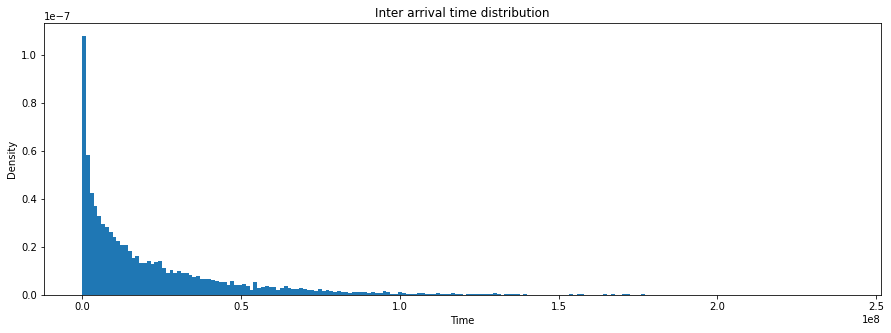

In [3]:
times = data['Time'].values

plt.figure(figsize=(15,5))
delta_times = times[1:] - times[:-1]
mean_delta = delta_times.mean()
h = plt.hist(delta_times, bins=200, density=True)
plt.title("Inter arrival time distribution")
plt.xlabel("Time")
plt.ylabel("Density")
plt.show()

<ipython-input-4-74ebf30f5977>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


(19.5042, 50.3266)

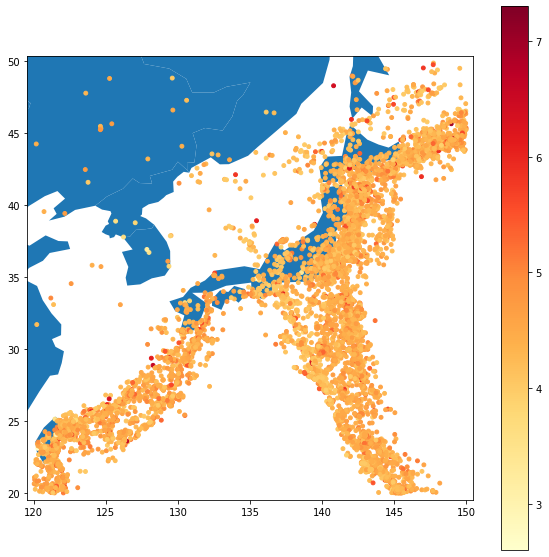

In [4]:
# Assuming 'data' is a DataFrame that includes 'Longitude' and 'Latitude' columns
geometry = [Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
gdf = GeoDataFrame(data, geometry=geometry)

# Load a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Calculate bounds of the GeoDataFrame
minx, miny, maxx, maxy = gdf.total_bounds

# Plotting
ax = world.plot(figsize=(10, 10))
gdf.plot(ax=ax, marker='o', column='Magnitude', markersize=15, cmap='YlOrRd', legend=True)

# Adjust the plotting range to center on the scatter
# You might want to add a small margin around the edges for better visualization
margin = 0.5  # Adjust this value based on your preference
ax.set_xlim(minx - margin, maxx + margin)
ax.set_ylim(miny - margin, maxy + margin)

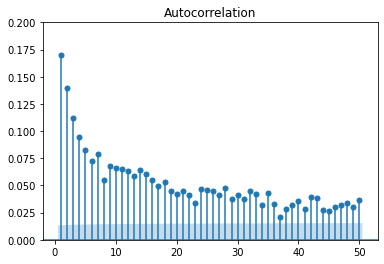

In [5]:
events_times = np.sort(data["Time"])

# Assuming `event_times` is a sorted NumPy array of event times
# Convert event times to counts per time bin for ACF analysis
time_bins = np.arange(events_times.min(), events_times.max(), 5000000)
event_counts = np.histogram(events_times, bins=time_bins)[0]

# Plot the ACF of event counts
plot_acf(event_counts, lags=50, alpha=0.01, zero=False) 
plt.ylim(0, 0.2)
plt.show()

In [6]:
def classify_magnitude(magnitude):
    if magnitude < 2:
        return 'tiny'
    elif 2 <= magnitude < 3:
        return 'very small'
    elif 3 <= magnitude < 4:
        return 'small'
    elif 4 <= magnitude < 5:
        return 'moderate'
    elif 5 <= magnitude < 6:
        return 'strong'
    else:
        return 'very strong'
    
data['Classification'] = data['Magnitude'].apply(classify_magnitude)

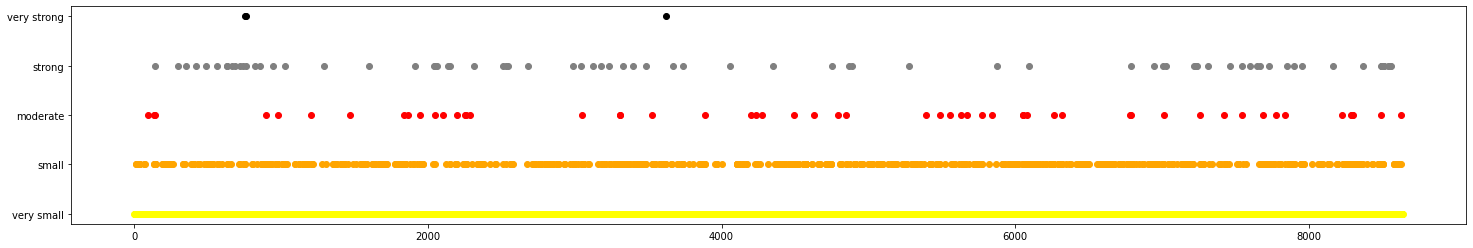

In [7]:
data["Time"] = data["Time"]/mean_delta
list_times = [data[data['Classification']==c]['Time'].values.astype(np.float64) for c in data['Classification'].unique()]

time_bins = np.arange(events_times.min(), events_times.max(), 5000000)
event_counts = [np.histogram(list_times[c], bins=time_bins)[0] for c in range(data['Classification'].nunique())]

label_encoder = LabelEncoder()
data['Classification_index'] = label_encoder.fit_transform(data['Classification']).astype(int)

plt.figure(figsize=(25,4))
colors = ['yellow', 'orange', 'red', 'grey', 'black']
for k in range(len(list_times)):
    plt.scatter(list_times[k], [k]*len(list_times[k]), color=colors[k])

# Set y-axis labels
classification_labels = ['very small', 'small', 'moderate', 'strong', 'very strong']
plt.yticks(range(len(classification_labels)), classification_labels)

plt.show()

In [8]:
#Fit the model to our data :

#Hawkes process for the earthquakes times
timestamps = data['Time'].values

ExpoEstimator = SumExpHawkesProcessInference(P=5)

# Estimate paramters
mu_hat, eta_hat, theta_hat = ExpoEstimator.estimate_grid(timestamps, T=timestamps[-1], return_params=True)

print("Estimated Hawkes parameters : mu = {0}, eta = {1}, theta = {2}".format(mu_hat, eta_hat, theta_hat))

#Gaussian mixture model earthquakes magnitudes
magnitudes = data['Magnitude'].values.reshape(-1,1)

gmm = GaussianMixture(50)

#Estimate parameters 
gmm.fit(magnitudes)

Estimated Hawkes parameters : mu = 0.44408893906626823, eta = 0.5566709696649418, theta = [ 0.08414457  0.98192191  3.84899651  5.43449017 20.62816313]


/home/lucas/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:131: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  cluster.KMeans(


GaussianMixture(n_components=50)

In [9]:
#Simulation of the Hawkes process

ExpoSimulator = SumExpHawkesProcessSimulation(mu=mu_hat, eta=eta_hat, theta_vec=theta_hat)

T_samples = ExpoSimulator.simulate(2000, seed=42)*mean_delta #2000 units of time roughly corresponds to one year

#Simulation of the Gaussian mixture

M_samples = gmm.sample(len(T_samples))[0].reshape(1,-1)[0]
#Generate submission

samples = [[T_samples[k], M_samples[k]] for k in range(len(T_samples))]